<a href="https://colab.research.google.com/github/m-pydych/GrafData-semestralka/blob/main/beans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BEANS

## Stažení dat a importy


In [ ]:
# data: https://github.com/AI-Lab-Makerere/ibean/?tab=readme-ov-file

# Dataset download and extract
!wget -q --show-progress -O train.zip https://storage.googleapis.com/ibeans/train.zip
!wget -q --show-progress -O validation.zip https://storage.googleapis.com/ibeans/validation.zip
!wget -q --show-progress -O test.zip https://storage.googleapis.com/ibeans/test.zip

!unzip -q -o train.zip
!unzip -q -o validation.zip
!unzip -q -o test.zip
print("\nunzip done")

train.zip           100%[===================>] 137.15M  16.3MB/s    in 9.9s    
validation.zip      100%[===================>]  17.65M  6.74MB/s    in 2.6s    
test.zip            100%[===================>]  16.89M  6.46MB/s    in 2.6s    

unzip done


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
from torchvision import transforms, datasets, models

import os
import time
import copy
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

## Charakteristika dat

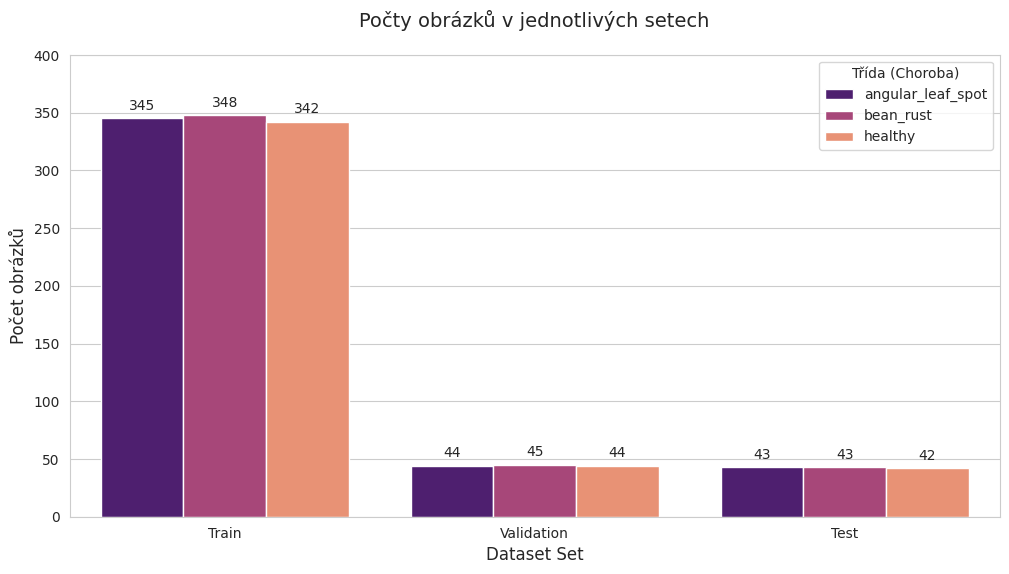

In [ ]:
def get_folder_counts(root_path):
    if not os.path.exists(root_path): return {}
    classes = sorted([d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))])
    return {cls: len([f for f in os.listdir(os.path.join(root_path, cls)) if os.path.isfile(os.path.join(root_path, cls, f))]) for cls in classes}

raw_counts = {
    'Train': get_folder_counts('train'),
    'Validation': get_folder_counts('validation'),
    'Test': get_folder_counts('test')
}

plot_data = []
for split, classes in raw_counts.items():
    for cls_name, count in classes.items():
        plot_data.append({'Split': split, 'Třída': cls_name, 'Počet obrázků': count})

df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df_plot, x='Split', y='Počet obrázků', hue='Třída', palette='magma')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontsize=10)

plt.title('Počty obrázků v jednotlivých setech', fontsize=14, pad=20)
plt.ylabel('Počet obrázků', fontsize=12)
plt.xlabel('Dataset Set', fontsize=12)
plt.ylim(0, max(df_plot['Počet obrázků']) * 1.15)
plt.legend(title='Třída (Choroba)')
plt.show()

## Preprocesing

In [ ]:
# DEFINIG TRANSFORMATIONS
# Base transformation for validation and test data (+ original train data)
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Crop + Flip
transform_1 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Rotation + Color
transform_2 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Crop + Flip + Rotation + Color
transform_1_and_2 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# APPLY TRANSFORMATION
val_dataset = datasets.ImageFolder(root='validation', transform=base_transform)
test_dataset = datasets.ImageFolder(root='test', transform=base_transform)

train_base = datasets.ImageFolder(root='train', transform=base_transform)
train_aug1 = datasets.ImageFolder(root='train', transform=transform_1)
train_aug2 = datasets.ImageFolder(root='train', transform=transform_2)
train_aug3 = datasets.ImageFolder(root='train', transform=transform_1_and_2)

# Merge base train data with augmented data
train_dataset = ConcatDataset([train_base, train_aug1, train_aug2, train_aug3])

# DATALOADERS
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

base_train_loader = DataLoader(train_base, batch_size=batch_size, shuffle=True)



print(f"Počet trénovacích vzorků (po expanzi): {len(train_dataset)}")
print(f"train classes: {train_base.classes}")
print(f"  val classes: {val_dataset.classes}")
print(f" test classes: {test_dataset.classes}")

Počet trénovacích vzorků (po expanzi): 4136
train classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
  val classes: ['angular_leaf_spot', 'bean_rust', 'healthy']
 test classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


## Definice funkcí pro trénování a vizualizaci

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Vývoj přesnosti (Accuracy)')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Vývoj ztráty (Loss)')
    plt.legend()

    plt.show()

# plot_history(history_x)

In [ ]:
def plot_confusion_matrix(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=loader.dataset.classes,
                yticklabels=loader.dataset.classes)
    plt.xlabel('Predikované')
    plt.ylabel('Skutečné')
    plt.title('Matice záměn (Confusion Matrix)')
    plt.show()

# plot_confusion_matrix(model_x, test_loader)

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100. * correct / total
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss/len(train_loader))
        history['val_loss'].append(val_loss/len(val_loader))
        history['train_acc'].append(100.*correct/total)
        history['val_acc'].append(100.*val_correct/val_total)

        print(f"Epocha {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
            # print(f"  --> Model uložen (lepši Val Loss)")
        else:
            patience_counter += 1
            # print(f"  --> Žádné zlepšení. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\nEarly stopping aktivován po {epoch+1} epochách.")
            break

    model.load_state_dict(best_model_wts)

    print(f"\nCelková časová náročnost: {time.time() - start_time:.2f} s")
    return history


# history_x = train_and_evaluate(model_x, train_loader, val_loader, epochs=15, patience=3)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Definice modelů

základní model bez použití pokročilejších technik

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class RegularizedCNN(nn.Module):
    def __init__(self):
        super(RegularizedCNN, self).__init__()
        #  224x224 -> 112x112
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # 112x112 -> 56x56
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # 56x56 -> 28x28
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Clasification
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x


In [ ]:
model_3 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in model_3.parameters():
    param.requires_grad = False

num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 3)


# Trénink

In [ ]:
model_0 = SimpleCNN().to(device)
history_0 = train_and_evaluate(model_0, base_train_loader, val_loader, epochs=15, patience=3)
# Baseline model trénovaný na trénovacích datech bez nově vytvořených

Epocha 1: Train Acc: 44.87% | Val Acc: 45.86% | Val Loss: 0.9950
Epocha 2: Train Acc: 62.57% | Val Acc: 63.16% | Val Loss: 0.7560
Epocha 3: Train Acc: 75.53% | Val Acc: 66.17% | Val Loss: 0.6524
Epocha 4: Train Acc: 82.98% | Val Acc: 69.17% | Val Loss: 0.6436
Epocha 5: Train Acc: 90.81% | Val Acc: 70.68% | Val Loss: 0.7530
Epocha 6: Train Acc: 97.68% | Val Acc: 68.42% | Val Loss: 0.8471
Epocha 7: Train Acc: 98.84% | Val Acc: 72.18% | Val Loss: 0.8317

Early stopping aktivován po 7 epochách.

Celková časová náročnost: 55.06 s


In [ ]:
model_1 = SimpleCNN().to(device)
history_1 = train_and_evaluate(model_1, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 66.22% | Val Acc: 71.43% | Val Loss: 0.5876
Epocha 2: Train Acc: 78.43% | Val Acc: 73.68% | Val Loss: 0.5347
Epocha 3: Train Acc: 83.85% | Val Acc: 78.95% | Val Loss: 0.4371
Epocha 4: Train Acc: 86.51% | Val Acc: 77.44% | Val Loss: 0.5290
Epocha 5: Train Acc: 90.14% | Val Acc: 78.20% | Val Loss: 0.5629
Epocha 6: Train Acc: 92.63% | Val Acc: 82.71% | Val Loss: 0.4077
Epocha 7: Train Acc: 92.77% | Val Acc: 78.20% | Val Loss: 0.6325
Epocha 8: Train Acc: 94.27% | Val Acc: 79.70% | Val Loss: 0.4367
Epocha 9: Train Acc: 95.21% | Val Acc: 81.20% | Val Loss: 0.5847

Early stopping aktivován po 9 epochách.

Celková časová náročnost: 348.49 s


In [ ]:
model_2 = RegularizedCNN().to(device)
history_2 = train_and_evaluate(model_2, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 64.63% | Val Acc: 78.20% | Val Loss: 0.5284
Epocha 2: Train Acc: 74.13% | Val Acc: 75.19% | Val Loss: 0.5118
Epocha 3: Train Acc: 77.93% | Val Acc: 78.20% | Val Loss: 0.5453
Epocha 4: Train Acc: 79.01% | Val Acc: 77.44% | Val Loss: 0.4396
Epocha 5: Train Acc: 82.06% | Val Acc: 79.70% | Val Loss: 0.4035
Epocha 6: Train Acc: 85.44% | Val Acc: 81.95% | Val Loss: 0.4494
Epocha 7: Train Acc: 87.55% | Val Acc: 82.71% | Val Loss: 0.3731
Epocha 8: Train Acc: 88.10% | Val Acc: 84.96% | Val Loss: 0.3729
Epocha 9: Train Acc: 91.39% | Val Acc: 84.96% | Val Loss: 0.3657
Epocha 10: Train Acc: 92.34% | Val Acc: 86.47% | Val Loss: 0.3494
Epocha 11: Train Acc: 93.25% | Val Acc: 84.96% | Val Loss: 0.3078
Epocha 12: Train Acc: 94.25% | Val Acc: 87.97% | Val Loss: 0.3557
Epocha 13: Train Acc: 94.68% | Val Acc: 87.97% | Val Loss: 0.3465
Epocha 14: Train Acc: 94.32% | Val Acc: 88.72% | Val Loss: 0.3020
Epocha 15: Train Acc: 95.21% | Val Acc: 90.98% | Val Loss: 0.2902

Celková časová nár

In [ ]:
model_3 = model_3.to(device)
history_3 = train_and_evaluate(model_3, train_loader, val_loader, epochs=15, patience=3)

Epocha 1: Train Acc: 73.40% | Val Acc: 90.23% | Val Loss: 0.3340
Epocha 2: Train Acc: 86.10% | Val Acc: 91.73% | Val Loss: 0.2752
Epocha 3: Train Acc: 86.07% | Val Acc: 92.48% | Val Loss: 0.2180
Epocha 4: Train Acc: 89.34% | Val Acc: 91.73% | Val Loss: 0.2066
Epocha 5: Train Acc: 89.31% | Val Acc: 93.23% | Val Loss: 0.1936
Epocha 6: Train Acc: 90.21% | Val Acc: 92.48% | Val Loss: 0.1807
Epocha 7: Train Acc: 89.94% | Val Acc: 90.98% | Val Loss: 0.1985
Epocha 8: Train Acc: 91.01% | Val Acc: 92.48% | Val Loss: 0.1791
Epocha 9: Train Acc: 90.26% | Val Acc: 90.98% | Val Loss: 0.1867
Epocha 10: Train Acc: 90.28% | Val Acc: 92.48% | Val Loss: 0.1611
Epocha 11: Train Acc: 91.13% | Val Acc: 91.73% | Val Loss: 0.1608
Epocha 12: Train Acc: 91.68% | Val Acc: 91.73% | Val Loss: 0.1627
Epocha 13: Train Acc: 90.47% | Val Acc: 92.48% | Val Loss: 0.1464
Epocha 14: Train Acc: 91.63% | Val Acc: 92.48% | Val Loss: 0.1504
Epocha 15: Train Acc: 91.49% | Val Acc: 93.23% | Val Loss: 0.1534

Celková časová nár

## Results

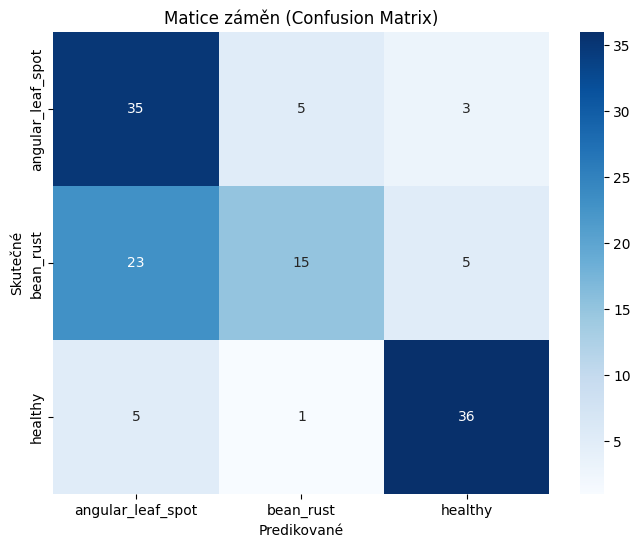

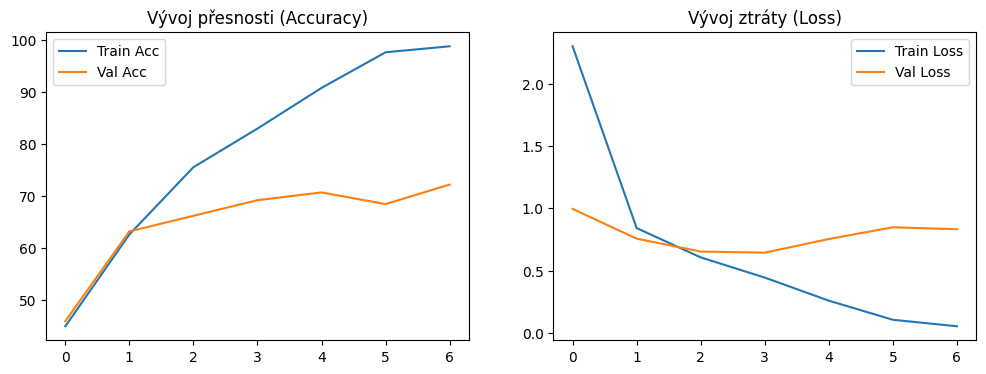

In [ ]:
# jenom base model
plot_confusion_matrix(model_0, test_loader)
plot_history(history_0)

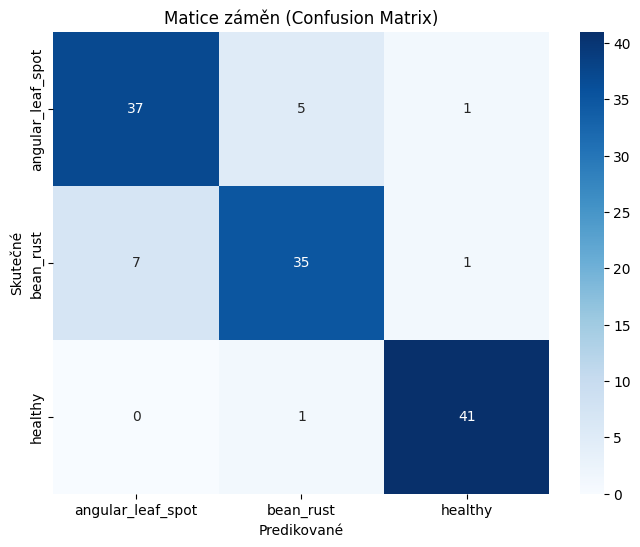

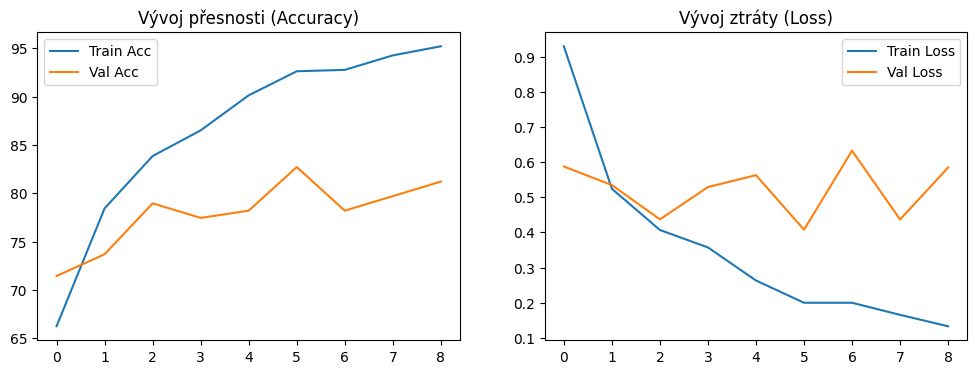

In [ ]:
# preprocesing + base model
plot_confusion_matrix(model_1, test_loader)
plot_history(history_1)

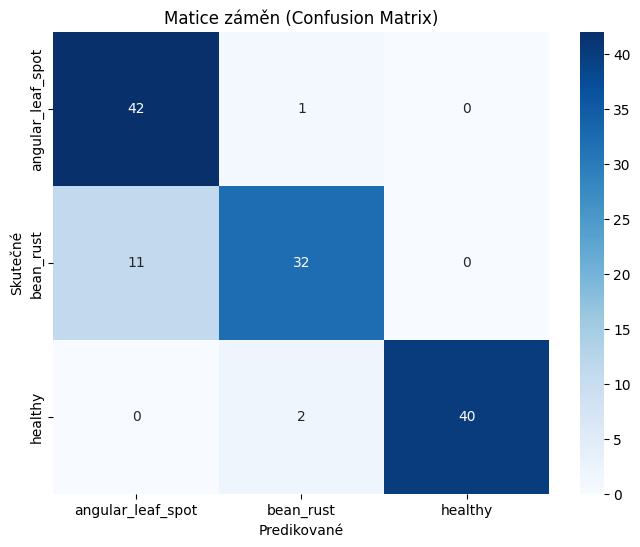

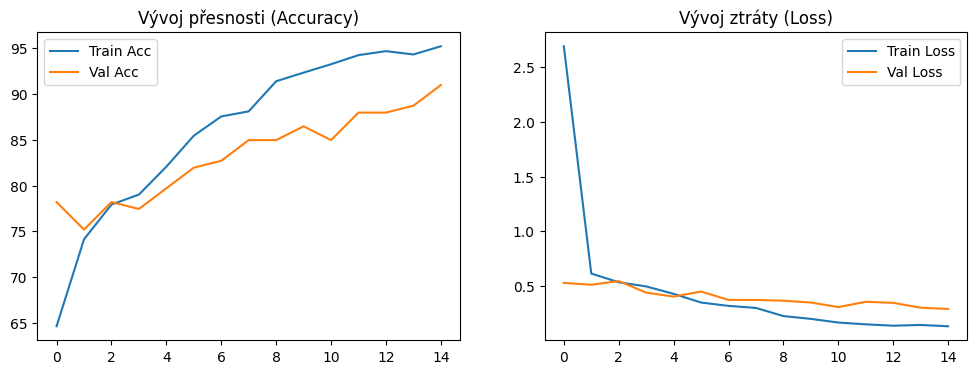

In [ ]:
# preprocesing + advanced model
plot_confusion_matrix(model_2, test_loader)
plot_history(history_2)

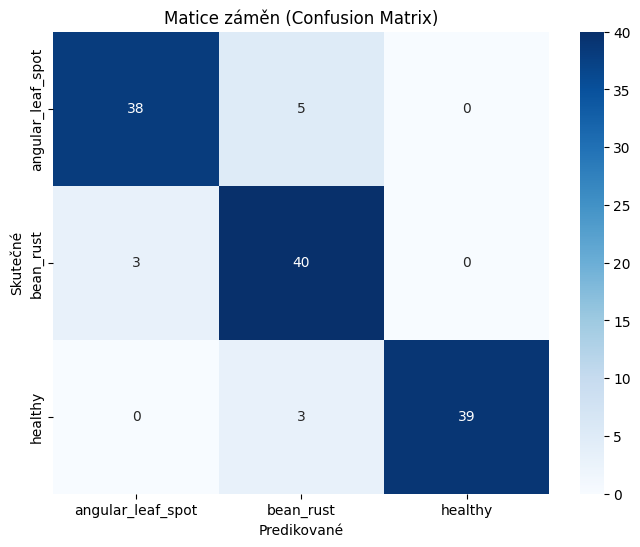

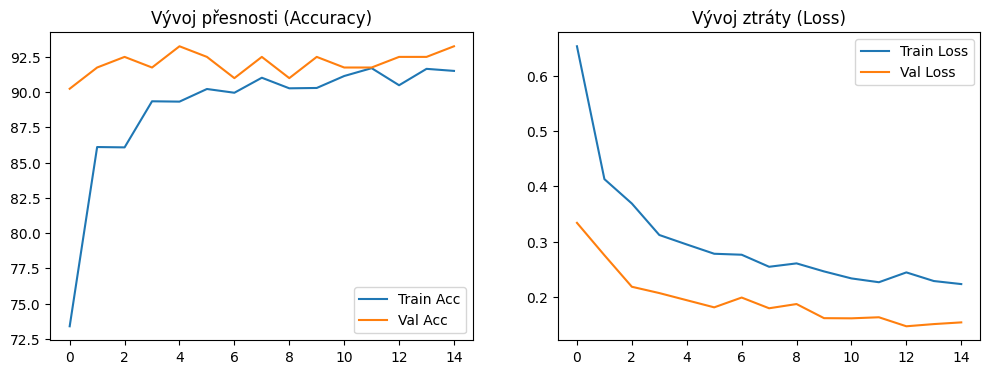

In [ ]:
# preprocesing + pretrained model
plot_confusion_matrix(model_3, test_loader)
plot_history(history_3)

SROVNÁNÍ VÝKONNOSTI MODELŮ:


,Model,Max Val Acc (%),Min Val Loss,Epochy
0,Model 0 (Základní),72.180451,0.643575,7
1,Model 1 (Augmentace),82.706767,0.407683,9
2,Model 2 (Regulace),90.977444,0.290249,15
3,Model 3 (Transfer L.),93.233083,0.146385,15


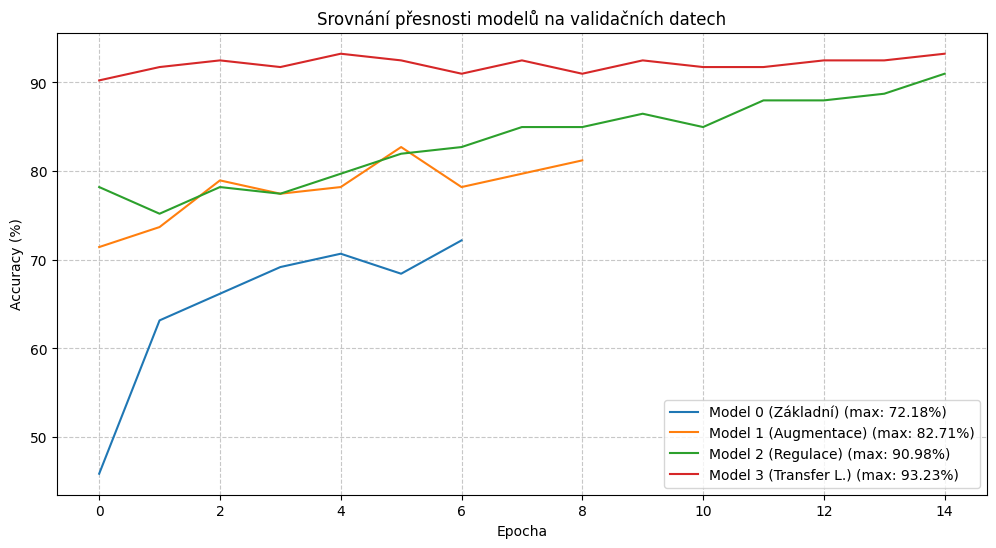

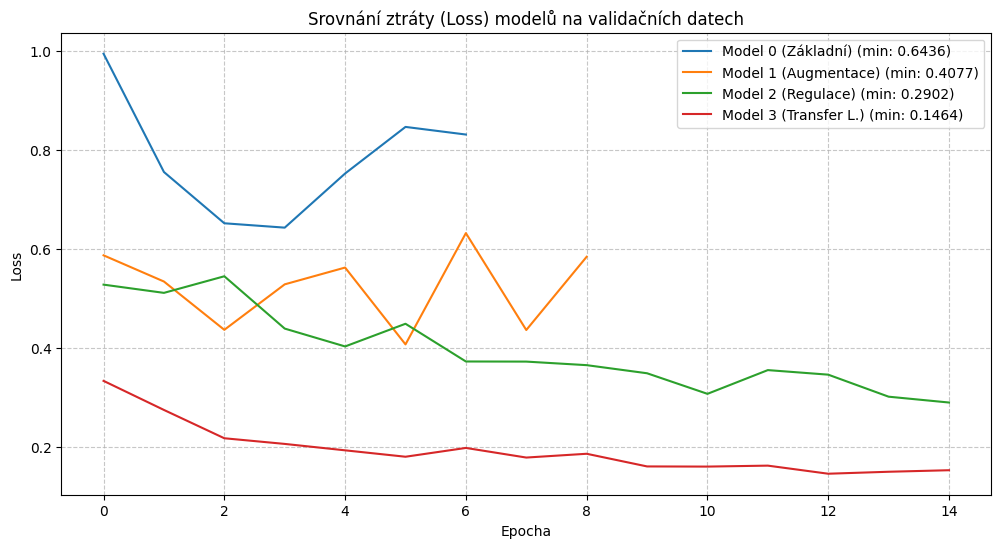

In [ ]:
models_data = {
    'Model 0 (Základní)': history_0,
    'Model 1 (Augmentace)': history_1,
    'Model 2 (Regulace)': history_2,
    'Model 3 (Transfer L.)': history_3
}

comparison_list = []

for name, hist in models_data.items():
    comparison_list.append({
        'Model': name,
        'Max Val Acc (%)': max(hist['val_acc']),
        'Min Val Loss': min(hist['val_loss']),
        'Epochy': len(hist['val_acc'])
    })

df_comparison = pd.DataFrame(comparison_list)

print("SROVNÁNÍ VÝKONNOSTI MODELŮ:")
display(df_comparison)

plt.figure(figsize=(12, 6))

for name, hist in models_data.items():
    plt.plot(hist['val_acc'], label=f'{name} (max: {max(hist["val_acc"]):.2f}%)')

plt.title('Srovnání přesnosti modelů na validačních datech')
plt.xlabel('Epocha')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(12, 6))

for name, hist in models_data.items():
    plt.plot(hist['val_loss'], label=f'{name} (min: {min(hist["val_loss"]):.4f})')

plt.title('Srovnání ztráty (Loss) modelů na validačních datech')
plt.xlabel('Epocha')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
def evaluate_final(model, loader, device):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total), (total_loss / len(loader))

results = []
models = [
    (model_0, history_0, "Model 0"),
    (model_1, history_1, "Model 1"),
    (model_2, history_2, "Model 2"),
    (model_3, history_3, "Model 3")
]

for model, history, name in models:
    best_val_acc = max(history['val_acc'])

    test_acc, test_loss = evaluate_final(model, test_loader, device)

    results.append({
        'Architektura': name,
        'Val. Accuracy (%)': round(best_val_acc, 2),
        'Test Accuracy (%)': round(test_acc, 2),
        'Test Loss': round(test_loss, 4)
    })

df_results = pd.DataFrame(results)
display(df_results)

,Architektura,Val. Accuracy (%),Test Accuracy (%),Test Loss
0,Model 0,72.18,67.19,0.7175
1,Model 1,82.71,88.28,0.3080
2,Model 2,90.98,89.06,0.2980
3,Model 3,93.23,91.41,0.2593
